In [1]:
import torch
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

torch.cuda.is_available()

torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4080 SUPER'

In [2]:

# Define paths to images and masks
IMAGE_PATH = "DataSet/Kvasir/images"
MASK_PATH = "DataSet/Kvasir/masks"
IMG_HEIGHT, IMG_WIDTH = 256, 256


# Custom Dataset Class
class PolypSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.jpg', '.png'))])
        self.transform = transform

        # Ensure valid dataset
        if len(self.image_files) == 0 or len(self.mask_files) == 0:
            raise ValueError("No valid image or mask files found in the specified directories.")
        if len(self.image_files) != len(self.mask_files):
            raise ValueError("Mismatch in the number of images and masks.")

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image and mask
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        image = Image.open(img_path).convert("RGB")  # Ensure 3-channel RGB
        mask = Image.open(mask_path).convert("L")   # Ensure 1-channel grayscale
        
        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Binarize the mask to ensure values are 0 or 1
        mask = (mask > 0.5).float()

        return image, mask

# Transformations for images and masks
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),  # Resize images and masks
    transforms.ToTensor()                        # Convert to tensors and normalize to [0, 1]
])

# Initialize dataset and dataloader
dataset = PolypSegmentationDataset(IMAGE_PATH, MASK_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Inspect a batch
for images, masks in dataloader:
    print(f"Image batch shape: {images.shape}")  # Shape: [batch_size, 3, IMG_HEIGHT, IMG_WIDTH]
    print(f"Mask batch shape: {masks.shape}")    # Shape: [batch_size, 1, IMG_HEIGHT, IMG_WIDTH]
    break



Image batch shape: torch.Size([16, 3, 256, 256])
Mask batch shape: torch.Size([16, 1, 256, 256])


In [3]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

In [ ]:
# Initialize the model
deeplab_model = smp.DeepLabV3(
    encoder_name="resnet34",           # Choose encoder
    encoder_weights="imagenet",        # Use ImageNet pre-trained weights
    in_channels=3,                     # Model input channels (3 for RGB images)
    classes=1,                         # Output channels (1 for binary segmentation)
)

# Define the loss function (Binary Cross-Entropy for binary segmentation)
loss_fn = nn.BCEWithLogitsLoss()

# Define the optimizer (Adam)
optimizer = optim.Adam(deeplab_model.parameters(), lr=1e-4)


In [ ]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeplab_model = deeplab_model.to(device)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    deeplab_model.train()  # Set model to training mode
    running_loss = 0.0
    
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)  # Move data to device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        predicted_mask = deeplab_model(images)

        # Calculate loss
        loss = loss_fn(predicted_mask, masks)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")


Epoch [1/20], Loss: 0.33289122936271487
Epoch [2/20], Loss: 0.15958561771918858
Epoch [3/20], Loss: 0.11196952135789962
Epoch [4/20], Loss: 0.08467173517223388
Epoch [5/20], Loss: 0.068662964221504
Epoch [6/20], Loss: 0.05783630505440727
Epoch [7/20], Loss: 0.050276564286341745
Epoch [8/20], Loss: 0.045777372247169885
Epoch [9/20], Loss: 0.04100061012875466
Epoch [10/20], Loss: 0.036388578691652844
Epoch [11/20], Loss: 0.032184272620176514
Epoch [12/20], Loss: 0.02948412529769398
Epoch [13/20], Loss: 0.03149785716382284
Epoch [14/20], Loss: 0.03865684086959514
Epoch [15/20], Loss: 0.038036823420534056
Epoch [16/20], Loss: 0.03047170720639683
Epoch [17/20], Loss: 0.02437366196323955
Epoch [18/20], Loss: 0.02543214625782437
Epoch [19/20], Loss: 0.021935129922533794
Epoch [20/20], Loss: 0.0192802877475818


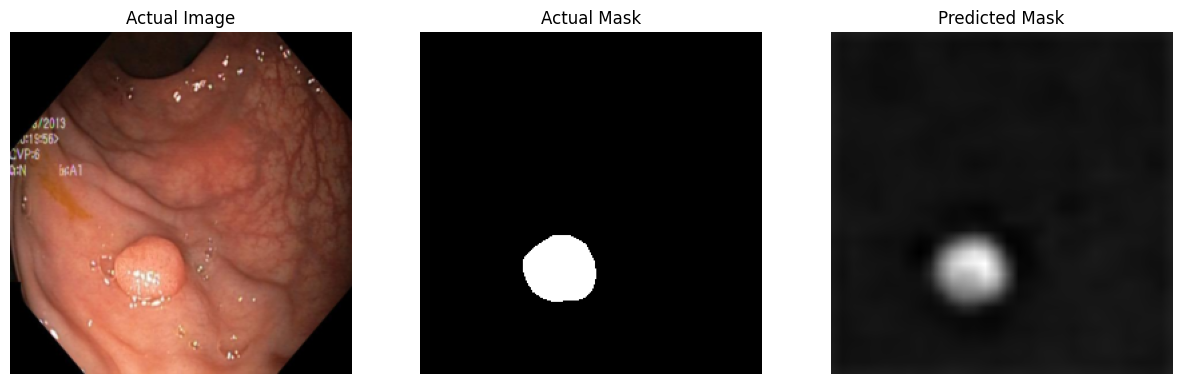

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a batch from the dataloader
images, masks = next(iter(dataloader))

# Pick the first image, mask, and predicted mask
image = images[0].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format
mask = masks[0].cpu().numpy().squeeze()  # Remove channel dimension if mask is 1 channel
predicted_mask = deeplab_model(images.to(device))[0].cpu().detach().numpy().squeeze()  # Get the predicted mask

# Plot the actual image, actual mask, and predicted mask side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Display image
ax[0].imshow(image)
ax[0].set_title("Actual Image")
ax[0].axis('off')

# Display actual mask
ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Actual Mask")
ax[1].axis('off')

# Display predicted mask
ax[2].imshow(predicted_mask, cmap='gray')
ax[2].set_title("Predicted Mask")
ax[2].axis('off')

plt.show()


In [ ]:

# Helper functions to calculate true positives, false positives, true negatives, and false negatives
def get_metrics(pred, target, threshold=0.5):
    # Convert to binary (0 or 1) predictions and targets
    pred = (pred > threshold).float()
    target = target.float()

    # Calculate True Positives, False Positives, True Negatives, False Negatives
    TP = (pred * target).sum()
    FP = ((1 - target) * pred).sum()
    TN = ((1 - pred) * (1 - target)).sum()
    FN = (target * (1 - pred)).sum()

    return TP, FP, TN, FN

# 1. Dice Similarity Coefficient (DSC)
def dice_coefficient(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return (2. * TP) / (2. * TP + FP + FN + 1e-6)

# 2. Intersection over Union (IoU)
def intersection_over_union(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return TP / (TP + FP + FN + 1e-6)

# 3. Accuracy
def accuracy(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return (TP + TN) / (TP + FP + TN + FN + 1e-6)

# 4. Sensitivity (Recall)
def sensitivity(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return TP / (TP + FN + 1e-6)

# 5. Specificity
def specificity(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return TN / (TN + FP + 1e-6)

# 6. Precision
def precision(pred, target, threshold=0.5):
    TP, FP, TN, FN = get_metrics(pred, target, threshold)
    return TP / (TP + FP + 1e-6)

# 7. F1-Score
def f1_score(pred, target, threshold=0.5):
    prec = precision(pred, target, threshold)
    rec = sensitivity(pred, target, threshold)
    return 2 * (prec * rec) / (prec + rec + 1e-6)

deeplab_model.eval()  # Set the model to evaluation mode

# Initialize empty lists to store metrics
dice_scores = []
iou_scores = []
accuracy_scores = []
sensitivity_scores = []
specificity_scores = []
precision_scores = []
f1_scores = []

# Iterate through the dataloader
for images, masks in dataloader:
    # Move tensors to GPU if necessary
    images = images.cuda()
    masks = masks.cuda()

    # Get the predicted mask from the model
    with torch.no_grad():
        predicted_mask = deeplab_model(images)

    # Compute the performance metrics
    dice_scores.append(dice_coefficient(predicted_mask, masks).item())
    iou_scores.append(intersection_over_union(predicted_mask, masks).item())
    accuracy_scores.append(accuracy(predicted_mask, masks).item())
    sensitivity_scores.append(sensitivity(predicted_mask, masks).item())
    specificity_scores.append(specificity(predicted_mask, masks).item())
    precision_scores.append(precision(predicted_mask, masks).item())
    f1_scores.append(f1_score(predicted_mask, masks).item())

# Calculate the average performance metrics across the dataset
print(f"Average Dice Coefficient: {sum(dice_scores) / len(dice_scores):.4f}")
print(f"Average Intersection over Union (IoU): {sum(iou_scores) / len(iou_scores):.4f}")
print(f"Average Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.4f}")
print(f"Average Sensitivity (Recall): {sum(sensitivity_scores) / len(sensitivity_scores):.4f}")
print(f"Average Specificity: {sum(specificity_scores) / len(specificity_scores):.4f}")
print(f"Average Precision: {sum(precision_scores) / len(precision_scores):.4f}")
print(f"Average F1-Score: {sum(f1_scores) / len(f1_scores):.4f}")


Average Dice Coefficient: 0.9814
Average Intersection over Union (IoU): 0.9635
Average Accuracy: 0.9944
Average Sensitivity (Recall): 0.9762
Average Specificity: 0.9976
Average Precision: 0.9867
Average F1-Score: 0.9814
